In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from modelnetvoxel import ModelNetDatasetVoxel
from cnn_model import Simple3DCNN, Simple3DCNN_BN

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

DATA_DIR = "ModelNet10"
SAVE_DIR = "ModelNet10Voxel"

num_classes = 10
grid_size = 32
object_size = 24
pitch_rescale = 1.0
no_of_rotations = 1

batch_size = 64

train_dataset = ModelNetDatasetVoxel(SAVE_DIR, train=True)
test_dataset = ModelNetDatasetVoxel(SAVE_DIR, train=False)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training device: {device}")

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training device: cuda


Unfortunately, the dataset is quite unbalanced. In particular, in the training dataset we observe some overrepresentation of the class chair, while bathtub class is underrepresented. 

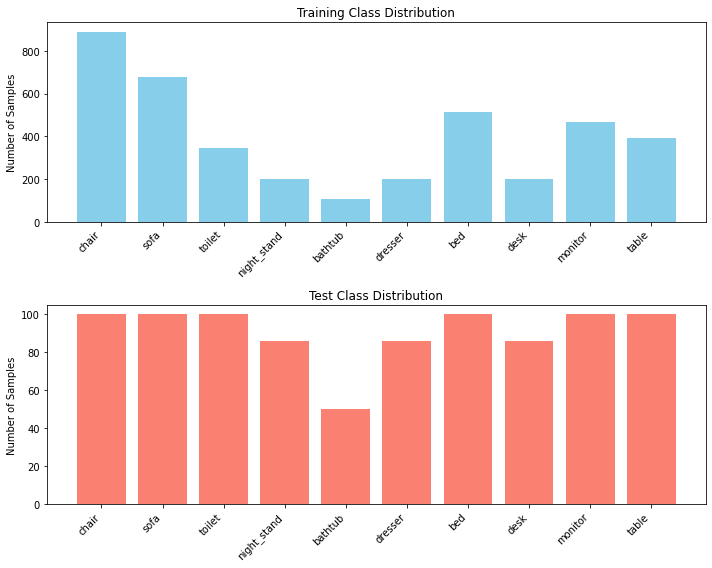

In [3]:
# Get the class names from the dataset
train_class_distribution = np.zeros(num_classes)
test_class_distribution = np.zeros(num_classes)
for label in train_dataset.labels:
    train_class_distribution[label] += 1

for label in test_dataset.labels:
    test_class_distribution[label] += 1
    
class_names = [train_dataset.class_map[i] for i in range(10)]

fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(10, 8))

# Plot training class distribution
axs[0].bar(range(10), train_class_distribution, color="skyblue")
axs[0].set_xticks(range(num_classes))
axs[0].set_xticklabels(class_names, rotation=45, ha="right")
axs[0].set_title("Training Class Distribution")
axs[0].set_ylabel("Number of Samples")

# Plot test class distribution
axs[1].bar(range(num_classes), test_class_distribution, color="salmon")
axs[1].set_xticks(range(num_classes))
axs[1].set_xticklabels(class_names, rotation=45, ha="right")
axs[1].set_title("Test Class Distribution")
axs[1].set_ylabel("Number of Samples")

plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
model = Simple3DCNN(num_classes).to(device)
summary(model, input_size=(batch_size, 1, grid_size, grid_size, grid_size))

In [ ]:
%load_ext autoreload
%autoreload 2
# Define your model, optimizer, and loss function
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # add weight_decay = 1e-4

# Define the number of epochs and initialize logs
num_epochs = 50
patience_epochs = 8
patience_epoch_count = 0
train_loss_log = []
val_loss_log = []
best_val = np.inf
val_loss_prev = np.inf
start_epoch = 0

resume_training = False
# Check if there's a saved checkpoint to resume training
checkpoint_path = "checkpoint.pt"
if os.path.exists(checkpoint_path) and resume_training:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    opt.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    train_loss_log = checkpoint["train_loss_log"]
    val_loss_log = checkpoint["val_loss_log"]
    best_val = checkpoint["best_val"]
    print(f"Resuming from epoch {start_epoch}")


for epoch_num in range(start_epoch, num_epochs):
    
    if patience_epoch_count > patience_epochs: 
        print(f"Early stopping at {patience_epoch_count} epochs!")
        break
    
    print("#################")
    print(f"# EPOCH {epoch_num}")

    ### TRAIN
    model.train()  # Training mode (e.g. enable dropout, batchnorm updates,...)
    train_losses = []
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        opt.zero_grad()
        
        # Move data to device
        batch_x, batch_y  = batch_x.unsqueeze(1).to(device), batch_y.to(device)

        # Forward pass
        out = model(batch_x)
        # Compute loss
        loss = loss_fn(out, batch_y)

        # Backpropagation
        loss.backward()

        # Update the weights
        opt.step()

        train_losses.append(loss.item())
        iterator.set_description(f"Train loss: {round(loss.item(), 2)}")

    avg_train_loss = np.mean(train_losses)
    train_loss_log.append(avg_train_loss)

    ### VALIDATION
    model.eval()  # Evaluation mode (e.g. disable dropout, batchnorm,...)
    val_losses = []
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient tracking
        for batch_x, batch_y in tqdm(test_dataloader):
            # Move data to device
            batch_x = batch_x.unsqueeze(1).to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            out = model(batch_x)

            val_losses.append(loss_fn(out, batch_y).item())

            _, predicted = torch.max(out, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    avg_val_loss = np.mean(val_losses)
    val_loss_log.append(avg_val_loss)
    val_acc = correct / total
    
    print(
        f"Average validation loss: {avg_val_loss:.3f}\tValidation accuracy: {val_acc:.3f}"
    )

    # Save the model and optimizer state at each epoch
    torch.save(
        {
            "epoch": epoch_num,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "train_loss_log": train_loss_log,
            "val_loss_log": val_loss_log,
            "best_val": best_val,
        },
        checkpoint_path,
    )

    if avg_val_loss < best_val:
        print("Update model!!!")
        torch.save(
            model.state_dict(), 
            f"best_{model.__class__.__name__}_val_loss_{round(avg_val_loss,3)}_val_acc_{round(val_acc,3)}.pt",
        )
        best_val = avg_val_loss
    
    if avg_val_loss > best_val:  
        patience_epoch_count += 1
        print("Incrementing patience epoch count: ", patience_epoch_count) 
    else:
        patience_epoch_count = 0
    
    val_loss_prev = avg_val_loss 

In [ ]:
# Load the model
model.load_state_dict(torch.load("best_Simple3DCNN_val_loss0.214_val_acc_0.924.pt"))
model.to(device)
# Set model to evaluation mode
model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_targets = []

iterator = tqdm(test_dataloader)
for inputs, targets in iterator:
    # Move data to device
    inputs = inputs.unsqueeze(1).to(device)
    targets = targets.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)

    # Convert outputs to predicted labels
    _, predicted = torch.max(outputs, 1)

    # Append to lists
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_targets, all_predictions)
print(f"Overall Accuracy: {overall_accuracy}")

# Calculate accuracy per class
class_names = [train_dataset.class_map.get(key) for key in range(num_classes)]
class_report = classification_report(
    all_targets, all_predictions, target_names=class_names
)
print("Classification Report:")
print(class_report)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()

# Print numerical values in each cell of the matrix
fmt = "d"
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.show()

In [ ]:
# Choose random samples
num_samples = 5  # Number of random samples to predict
random_indices = random.sample(range(len(test_dataset)), num_samples)

fig = plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    # Get a random sample from the test set
    sample, target = test_dataset[idx]
    sample = (
        sample.unsqueeze(0).unsqueeze(0).to(device)
    )  # Add batch dimension and move to device

    # Predict with the model
    with torch.no_grad():
        output = model(sample)
        _, predicted = torch.max(output, 1)

    # Convert predicted and target labels to numpy if needed
    predicted_label = predicted.item()
    true_label = target.item()  # Assuming target is a scalar label

    # Plot the voxel grid
    sample_np = (
        sample.cpu().squeeze().numpy()
    )  # Move sample to CPU and convert to numpy
    ax = fig.add_subplot(1, num_samples, i + 1, projection="3d")

    # Voxel plot
    sample_np = (sample_np + 1) / 2
    ax.voxels(sample_np, edgecolor="k")

    ax.set_title(
        f"Pred: {train_dataset.class_map.get(predicted_label)}, True: {train_dataset.class_map.get(true_label)}"
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, sample_np.shape[0])
    ax.set_ylim(0, sample_np.shape[1])
    ax.set_zlim(0, sample_np.shape[2])

plt.tight_layout()
plt.show()